# Case Housing Prices

## Etapas - 3a parte

* Modelo Random Forest Regressor
* Modelo LGBM

# Inspeção Inicial

In [ ]:
!pip install pycaret
!pip install xgboost

In [ ]:
# Ler todas as bibliotecas aqui
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from pycaret.regression import *
from xgboost import XGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Ler os dados aqui
#path = 'house_pricing.csv'
path = '/content/drive/MyDrive/Automated_ML_and_Deploy/Aula11_20230505/house_pricing.csv'
df_houses = pd.read_csv(path, sep=',')
df_houses.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,239000,3,1.0,1510,15022,1.0,0,3,0,1962,0,98003,47.330433,-122.303609,1510,12970
1,1260000,3,3.5,3220,3960,2.0,0,3,460,1991,0,98116,47.590933,-122.384230,3080,4444
2,414500,3,1.0,1050,6002,1.0,0,3,210,1941,0,98115,47.698761,-122.316010,1180,6003
3,252500,3,2.5,1780,7192,1.0,0,4,530,1974,0,98031,47.409319,-122.173484,1870,8500
4,389000,3,1.0,1330,3740,1.5,0,3,0,1903,0,98118,47.550242,-122.274232,1330,5053


# ML 

## Train Test Split

In [ ]:
df_train_houses, df_test_houses = train_test_split(df_houses, train_size=0.7, random_state=123)

In [ ]:
X_train = df_train_houses.drop(columns=('price'), axis = 1)
y_train = df_train_houses['price']

X_test = df_test_houses.drop(columns=('price'), axis = 1)
y_test = df_test_houses['price']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1291, 15) (1291,)
(554, 15) (554,)


## Modelo RFR

In [ ]:
n_estimators = [10,30,100,500,1000]
max_features = ['auto', 'sqrt']
max_depth = [5,15,30,50]
#min_samples_split = [2,5,10,20]
min_samples_leaf = [1,2,5,10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth' : max_depth,
               #'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rfr = RandomForestRegressor()
rfr_tuned = RandomizedSearchCV(estimator = rfr,
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = 3,
                               verbose = 2,
                               n_jobs = -1,
                               random_state = 42)
mdl_rfr = rfr_tuned.fit(X_train, y_train)
print(rfr_tuned.best_params_)

ypred_rfr = mdl_rfr.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 30, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}


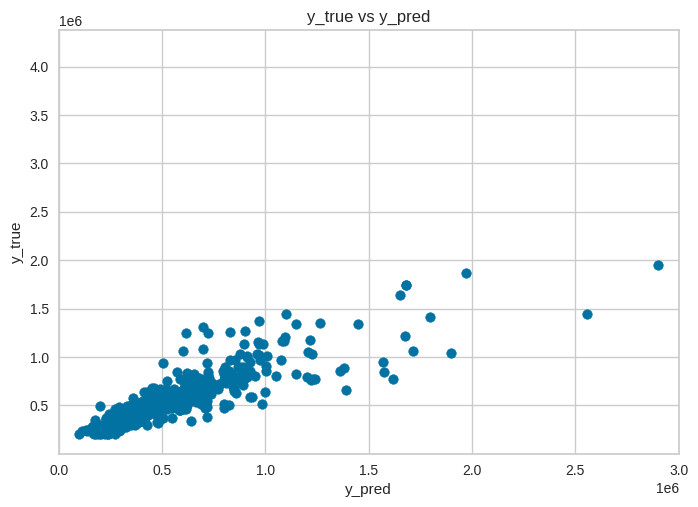

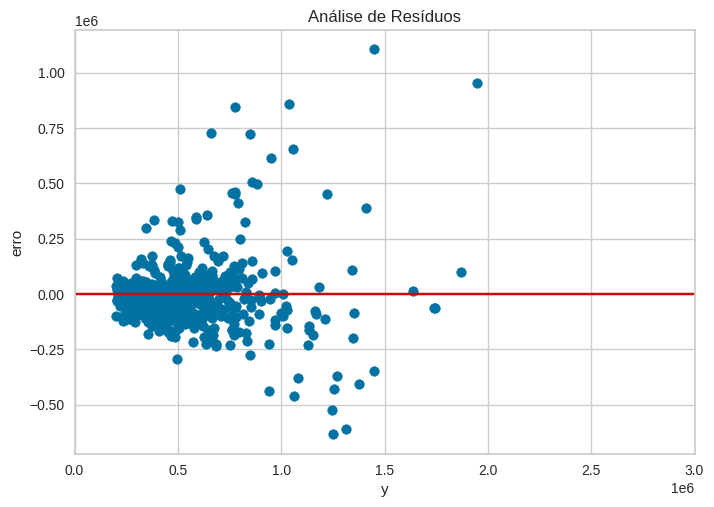

R2: 0.8072
MSE: 26445943008.9
RMSE: 162622.1
MAE: 96135.5
MAPE: 0.1812


[('RFR', 0.8072)]

In [ ]:
plt.scatter(x = y_test, y = ypred_rfr)
plt.title('y_true vs y_pred')
plt.xlim(0, 3e6)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

erro = (y_test - ypred_rfr)
plt.scatter(x = ypred_rfr, y = erro)
plt.title('Análise de Resíduos')
plt.xlim(0, 3e6)
plt.axhline(0, color='r')
plt.xlabel('y')
plt.ylabel('erro')
plt.show()

#Metricas
print(f'R2: {np.round(r2_score(y_test, ypred_rfr),4)}')
print(f'MSE: {np.round(mean_squared_error(y_test, ypred_rfr),1)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, ypred_rfr)),1)}')
print(f'MAE: {np.round(mean_absolute_error(y_test, ypred_rfr),1)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test, ypred_rfr),4)}')

#append r2 em uma tabela comparativa
comp_models = []
comp_models.append(('RFR',np.round(r2_score(y_test, ypred_rfr),4)))
comp_models

## Modelo LGBM

In [ ]:
random_grid = {'num_leaves': [27, 30, 50, 80, 120, 170, 230, 300], 
               'bagging_fraction': [0.5, 0.7, 0.8, 0.9],
              'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
              'boosting_type' : ['gbdt', 'dart'],
              'bagging_freq': [3, 9, 11, 15, 17, 23, 31],
              'max_depth': [3, 4, 5, 6, 7, 9, 11],       
              'feature_fraction': [0.5, 0.7, 0.8, 0.9],
              'lambda_l1': [0, 10, 20, 30, 40]} 

lgbm = LGBMRegressor()
lgbm_tuned = RandomizedSearchCV(estimator = lgbm,
                                param_distributions = random_grid,
                                n_iter = 100, cv = 2, 
                                verbose=10, random_state=42, n_jobs = -1)
mdl_lgbm = lgbm_tuned.fit(X_train.to_numpy(), y_train.to_numpy())
print(lgbm_tuned.best_params_)
ypred_lgbm = mdl_lgbm.predict(X_test.to_numpy())

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
{'num_leaves': 30, 'max_depth': 5, 'learning_rate': 0.3, 'lambda_l1': 20, 'feature_fraction': 0.7, 'boosting_type': 'dart', 'bagging_freq': 23, 'bagging_fraction': 0.7}


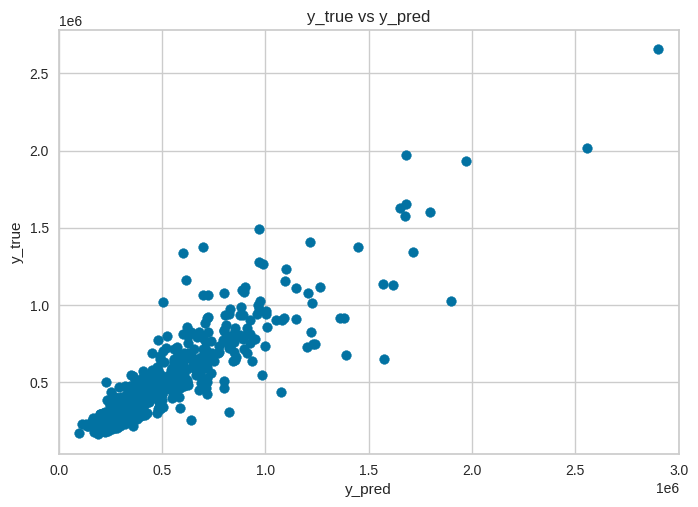

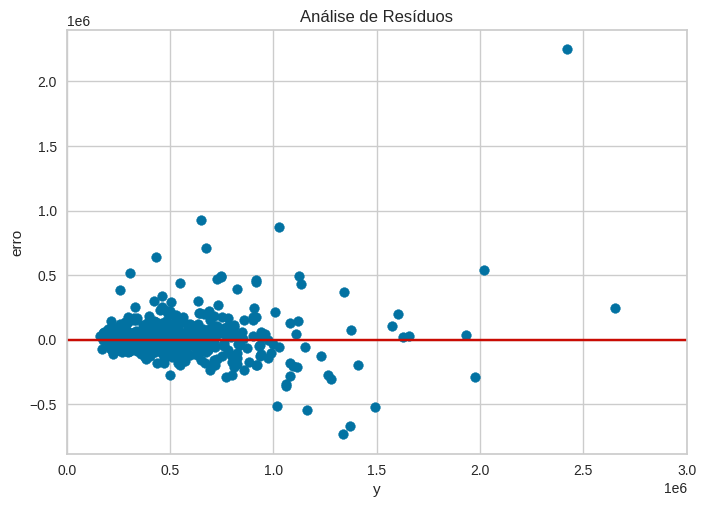

R2: 0.7697
MSE: 31592500778.2
RMSE: 177742.8
MAE: 97594.9
MAPE: 0.1765


In [ ]:
plt.scatter(x = y_test, y = ypred_lgbm)
plt.title('y_true vs y_pred')
plt.xlim(0, 3e6)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

erro = (y_test - ypred_lgbm)
plt.scatter(x = ypred_lgbm, y = erro)
plt.title('Análise de Resíduos')
plt.xlim(0, 3e6)
plt.axhline(0, color='r')
plt.xlabel('y')
plt.ylabel('erro')
plt.show()

#Metricas
print(f'R2: {np.round(r2_score(y_test, ypred_lgbm),4)}')
print(f'MSE: {np.round(mean_squared_error(y_test, ypred_lgbm),1)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, ypred_lgbm)),1)}')
print(f'MAE: {np.round(mean_absolute_error(y_test, ypred_lgbm),1)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test, ypred_lgbm),4)}')

#append r2 em uma tabela comparativa
comp_models.append(('LGBM',np.round(r2_score(y_test, ypred_lgbm),4)))

In [ ]:
comp_models

[('RFR', 0.8072), ('LGBM', 0.7697)]

# AutoML | Pycaret

## Setup


In [ ]:
s = setup(data = ?, #completar
          target = ?, #completar
          remove_outliers = True,
          session_id = 123)

In [ ]:
# check available models
#has to be called necessary only after having defined a setup.
?

## Compare Models

In [ ]:
#sort = 'mse', errors = 'raise')
best_model = ? #completar

## Criando Modelos

In [ ]:
#create model gbr
mdl_gbr = ? #completar

In [ ]:
#create model lightgbm
mdl_lightgbm = ? #completar

In [ ]:
#create model rf
mdl_rf = ? #completar

## Tuning dos Hiperparametros

In [ ]:
#tuning mdl_gbr
tuned_gbr = ? #completar

In [ ]:
#tuning mdl_lightgbm
tuned_lightgbm = ? #completar

In [ ]:
#tuning mdl_rf
tuned_rf = ? #completar

In [ ]:
#print params de cada modelo
for tuned_mdl in [tuned_gbr, tuned_lightgbm, tuned_rf]:
  print(tuned_mdl)
  display(tuned_mdl.get_params())
  print('')

GradientBoostingRegressor(random_state=123)


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


LGBMRegressor(random_state=123)


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


RandomForestRegressor(n_jobs=-1, random_state=123)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

Os hiperparametros acima indicam que os modelos podem apresentar tendencia de overfitting, considerando por exemplo:
* 'min_samples_leaf': 1,
* 'min_samples_split': 2,

## Análise dos Modelos


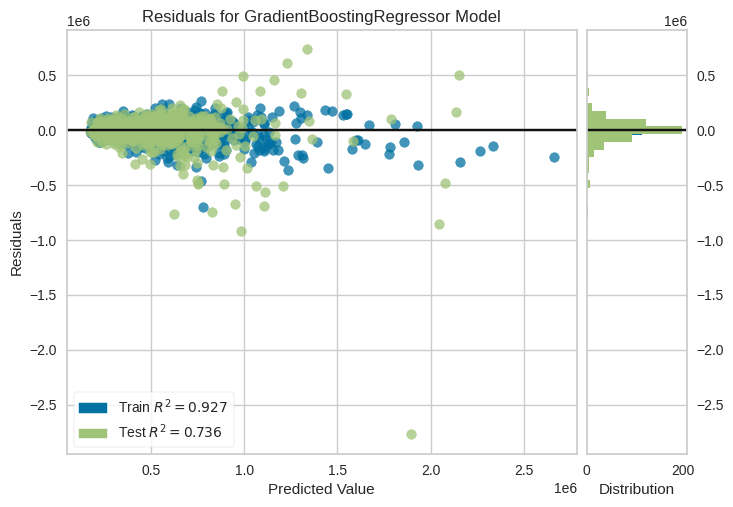

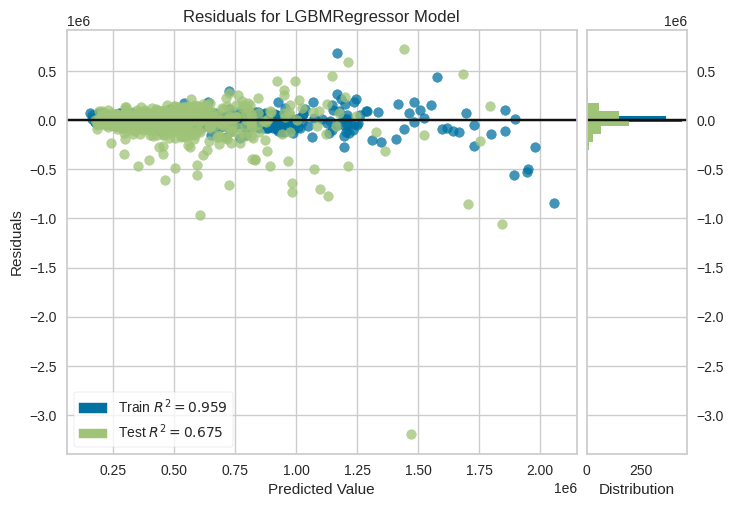

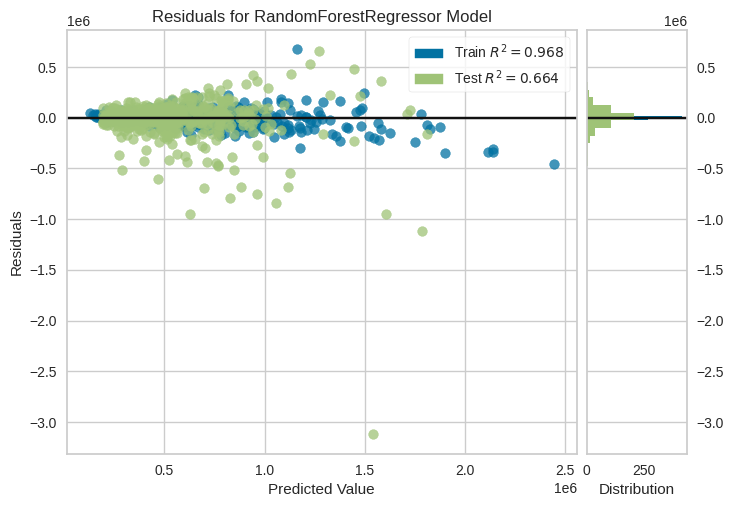

In [ ]:
for tuned_mdl in [tuned_gbr, tuned_lightgbm, tuned_rf]:
  plot_model(tuned_mdl)

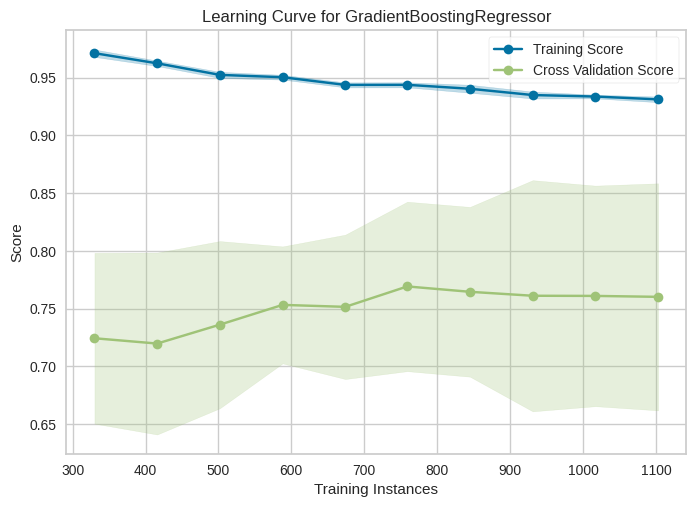

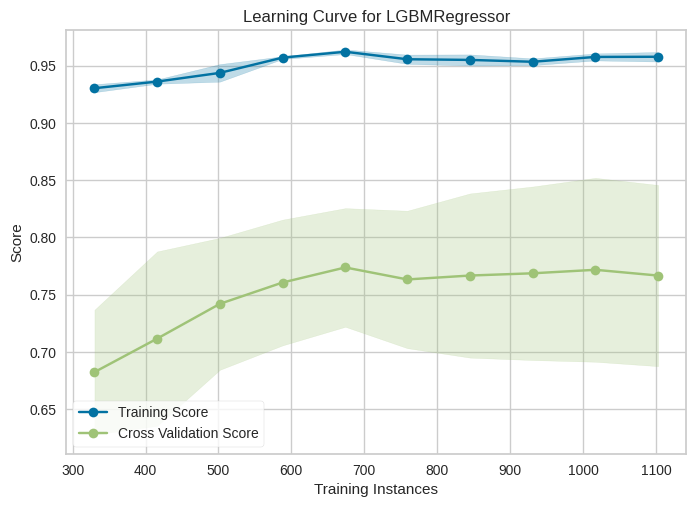

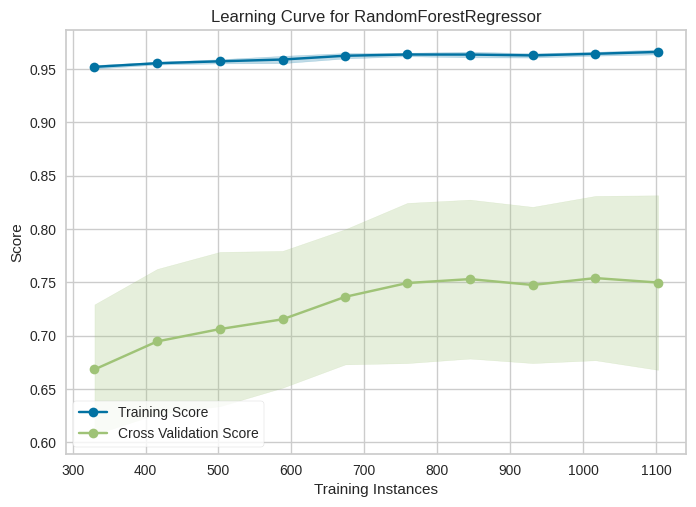

In [ ]:
for tuned_mdl in [tuned_gbr, tuned_lightgbm, tuned_rf]:
  plot_model(tuned_mdl, plot = 'learning')

# Comparativo entre os modelos

In [ ]:
# #gbr_R2
pred_gbr = predict_model(tuned_gbr)
r2_gbr = r2_score(pred_gbr['price'], pred_gbr['prediction_label'])
#append r2 em uma tabela comparativa
comp_models.append(('pycaret_GBR', np.round(r2_gbr,4)))

#lgbm_R2
pred_lgbm = predict_model(tuned_lightgbm)
r2_lgbm = r2_score(pred_lgbm['price'], pred_lgbm['prediction_label'])
#append r2 em uma tabela comparativa
comp_models.append(('pycaret_LGBM', np.round(r2_lgbm,4)))

#rf_R2
pred_rf = predict_model(tuned_rf)
r2_rf = r2_score(pred_rf['price'], pred_rf['prediction_label'])
#append r2 em uma tabela comparativa
comp_models.append(('pycaret_RF', np.round(r2_rf,4)))

display(comp_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,94050.1599,36165343124.0389,190171.8778,0.7363,0.2128,0.1639


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,100069.3582,44578579860.4953,211136.4011,0.6750,0.2284,0.1665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,102768.2643,46039758397.4606,214568.7731,0.6643,0.2391,0.1757


[('RFR', 0.8072),
 ('LGBM', 0.7697),
 ('pycaret_GBR', 0.7363),
 ('pycaret_LGBM', 0.675),
 ('pycaret_RF', 0.6643)]

* Baseado na tabela comparativa, o melhor modelo foi o Random Forest Regressor treinado sem AutoML (R2 = 0.8193).

* No entanto, para fins didáticos, no app a ser desenvolvido será utilizado o melhor modelo do AutoML Pycaret, que foi o Gradient Boost Regressor (R2 = 0.7363)

# Finalizando o Modelo e Salvando em Disco

* finalize_model:
This function trains a given model on the entire dataset including the hold-out set.

In [ ]:
finalize_model(tuned_gbr)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['num_bed', 'num_bath',
                                             'size_house', 'size_lot',
                                             'num_floors', 'is_waterfront',
                                             'condition', 'size_basement',
                                             'year_built', 'renovation_date',
                                             'zip', 'latitude', 'longitude',
                                             'avg_size_neighbor_houses',
                                             'avg_size_neighbor_lot'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=123))])

In [ ]:
# save pipeline
save_model(tuned_gbr, 'pycaret_mdl_gbr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['num_bed', 'num_bath',
                                              'size_house', 'size_lot',
                                              'num_floors', 'is_waterfront',
                                              'condition', 'size_basement',
                                              'year_built', 'renovation_date',
                                              'zip', 'latitude', 'longitude',
                                              'avg_size_neighbor_houses',
                                              'avg_size_neighbor_lot'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_outliers',
                  Transfor